# Ethereum Gas Fee Analysis and Forecasting: A Wallet-to-Network Perspective

<img src="img/ethscan.jpeg" alt="Etherscan Pic" style="width:100%; height:400px; display:block;">

## 💫 **1. Overview**

This project analyzes Ethereum network transaction fees and average gas prices to understand how network activity, cost patterns, and time-dependent fluctuations evolve over time.  

Two real datasets were used:

- **Wallet Insights:** on-chain transaction records from a specific Ethereum address, including transaction fee (ETH, USD) and timestamps.  
- **Average Gas Price Chart:** daily network-level gas prices (in Wei → converted to Gwei) obtained from Etherscan.  

The goal was to explore temporal patterns in gas prices and wallet-specific transaction fees, compare weekday versus weekend behavior, and assess the predictability of network costs using time series forecasting (ARIMA).  

This analysis helps illustrate the relationship between network congestion, user-level costs, and overall fee predictability in a live blockchain environment.


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
path = os.getcwd()
print(path)

C:\Users\User\Projects\Ethereum_Gas_Fee_Analysis


## 🌿 **2. Data Preparation and Frame Integration**

The data preparation process involved multiple transformation stages, resulting in four key DataFrames used for analysis and forecasting:

- **`df1`** → the **wallet dataset**, containing detailed on-chain transaction data for a specific Ethereum address.  
  This frame was cleaned and preprocessed by converting the `DateTime (UTC)` column into `date`, `time`, and `hour` components, enabling time-based analyses such as hourly and weekday patterns of transaction fees.

- **`df2`** → the **average gas price dataset**, sourced from Etherscan’s gas price history.  
  It includes daily average gas prices, originally measured in Wei and later converted to Gwei, reflecting overall network-level gas trends.

- **`df3`** → a **filtered subset of `df1`**, containing only the essential columns — `Date`, `TxnFee(ETH)`, and `TxnFee(USD)` — representing daily median wallet fees.  
  This frame isolates user-level fee behavior in a compact form suitable for merging with network-wide data.

- **`df_clean`** → the **final merged dataset**, created by joining `df3` and `df2` on the `Date` column.  
  It combines wallet-specific fee information with network-wide gas price data, allowing for direct comparison and correlation analysis.

After aligning both datasets by date, `df_clean` became the main frame used for visualization and forecasting.  
It contains one record per day with key metrics:

- `TxnFee(ETH)` and `TxnFee(USD)` → daily median transaction fees from the wallet  
- `Value (Gwei)` → daily average gas price from the Ethereum network  


In [5]:
df1 = pd.read_csv(r"csv/transactions_etherscan.csv")
df1.head()

,Transaction Hash,Blockno,UnixTimestamp,DateTime (UTC),From,To,ContractAddress,Value_IN(ETH),Value_OUT(ETH),CurrentValue @ $4081.04274641846/Eth,TxnFee(ETH),TxnFee(USD),Historical $Price/Eth,Status,ErrCode,Method
0,0x9f749f8455c94f5ae9666e84dd11e891a4e675785aca...,22366772,1745833739,2025-04-28 09:48:59,0x6d3b90747dbf5883bf88ff7eb5fcc86f408b5409,0xb60acd2057067dc9ed8c083f5aa227a244044fd6,NaN,0.00000,0.0035,14.283650,0.000064,0.260016,1800.19,NaN,NaN,Request Unstake
1,0xcde436236c96578e99989de764506943b9a2e741f31c...,22371619,1745892287,2025-04-29 02:04:47,0xb4a3c2debfc033ee3399ad6adf0b4fc74db92baa,0x6d3b90747dbf5883bf88ff7eb5fcc86f408b5409,NaN,0.05870,0.0000,239.557209,0.000009,0.038739,1798.47,NaN,NaN,Transfer
2,0xe186980a9a92108d496c3cc87a3d67ed2084591f83cf...,22371854,1745895143,2025-04-29 02:52:23,0x6d3b90747dbf5883bf88ff7eb5fcc86f408b5409,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,NaN,0.00000,0.0000,0.000000,0.000021,0.084258,1798.47,NaN,NaN,Transfer
3,0x17cb03a81923f1ed2708cbcd1ab1991abd6623dbd864...,22371862,1745895239,2025-04-29 02:53:59,0x6d3b90747dbf5883bf88ff7eb5fcc86f408b5409,0xb60acd2057067dc9ed8c083f5aa227a244044fd6,NaN,0.00000,0.0035,14.283650,0.000078,0.318759,1798.47,NaN,NaN,Request Unstake
4,0xf88f300fa9936ed20f1383e499b8bf395e32fcbdb1b9...,22381870,1746016223,2025-04-30 12:30:23,0x102407f67415dcc4068370625ca27f24bb2a03d5,0x6d3b90747dbf5883bf88ff7eb5fcc86f408b5409,NaN,43.89617,0.0000,179142.148108,0.000011,0.045129,1793.83,NaN,NaN,Transfer


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Transaction Hash                      1910 non-null   object 
 1   Blockno                               1910 non-null   int64  
 2   UnixTimestamp                         1910 non-null   int64  
 3   DateTime (UTC)                        1910 non-null   object 
 4   From                                  1910 non-null   object 
 5   To                                    1910 non-null   object 
 6   ContractAddress                       0 non-null      float64
 7   Value_IN(ETH)                         1910 non-null   float64
 8   Value_OUT(ETH)                        1910 non-null   float64
 9   CurrentValue @ $4081.04274641846/Eth  1910 non-null   float64
 10  TxnFee(ETH)                           1910 non-null   float64
 11  TxnFee(USD)      

In [8]:
# find if there is any nan value so we can drop it (final result, no exists)
df1["TxnFee(ETH)"].isna().value_counts()

TxnFee(ETH)
False    1910
Name: count, dtype: int64

In [9]:
# check if fee is below 0 to drop rows
(df1["TxnFee(ETH)"]<0).sum()

np.int64(0)

In [10]:
# this creates a normal string to a pandas string and we can do time arithmetic such as dt.time
df1["DateTime (UTC)"] = pd.to_datetime(df1["DateTime (UTC)"], utc = True, errors = "coerce")

df1["Date"] = df1["DateTime (UTC)"].dt.date
df1["Hour"] = df1["DateTime (UTC)"].dt.hour
df1["Weekday"] = df1["DateTime (UTC)"].dt.day_name()
df1["is_weekend"] = df1["DateTime (UTC)"].dt.dayofweek>=5

In [11]:
df1.head()

,Transaction Hash,Blockno,UnixTimestamp,DateTime (UTC),From,To,ContractAddress,Value_IN(ETH),Value_OUT(ETH),CurrentValue @ $4081.04274641846/Eth,TxnFee(ETH),TxnFee(USD),Historical $Price/Eth,Status,ErrCode,Method,Date,Hour,Weekday,is_weekend
0,0x9f749f8455c94f5ae9666e84dd11e891a4e675785aca...,22366772,1745833739,2025-04-28 09:48:59+00:00,0x6d3b90747dbf5883bf88ff7eb5fcc86f408b5409,0xb60acd2057067dc9ed8c083f5aa227a244044fd6,NaN,0.00000,0.0035,14.283650,0.000064,0.260016,1800.19,NaN,NaN,Request Unstake,2025-04-28,9,Monday,False
1,0xcde436236c96578e99989de764506943b9a2e741f31c...,22371619,1745892287,2025-04-29 02:04:47+00:00,0xb4a3c2debfc033ee3399ad6adf0b4fc74db92baa,0x6d3b90747dbf5883bf88ff7eb5fcc86f408b5409,NaN,0.05870,0.0000,239.557209,0.000009,0.038739,1798.47,NaN,NaN,Transfer,2025-04-29,2,Tuesday,False
2,0xe186980a9a92108d496c3cc87a3d67ed2084591f83cf...,22371854,1745895143,2025-04-29 02:52:23+00:00,0x6d3b90747dbf5883bf88ff7eb5fcc86f408b5409,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,NaN,0.00000,0.0000,0.000000,0.000021,0.084258,1798.47,NaN,NaN,Transfer,2025-04-29,2,Tuesday,False
3,0x17cb03a81923f1ed2708cbcd1ab1991abd6623dbd864...,22371862,1745895239,2025-04-29 02:53:59+00:00,0x6d3b90747dbf5883bf88ff7eb5fcc86f408b5409,0xb60acd2057067dc9ed8c083f5aa227a244044fd6,NaN,0.00000,0.0035,14.283650,0.000078,0.318759,1798.47,NaN,NaN,Request Unstake,2025-04-29,2,Tuesday,False
4,0xf88f300fa9936ed20f1383e499b8bf395e32fcbdb1b9...,22381870,1746016223,2025-04-30 12:30:23+00:00,0x102407f67415dcc4068370625ca27f24bb2a03d5,0x6d3b90747dbf5883bf88ff7eb5fcc86f408b5409,NaN,43.89617,0.0000,179142.148108,0.000011,0.045129,1793.83,NaN,NaN,Transfer,2025-04-30,12,Wednesday,False


In [31]:
df2 = pd.read_csv(r"csv/avggasprice.csv")
df2.tail()

,Date(UTC),UnixTimeStamp,Value (Wei)
3737,10/22/2025,1761091200,1155038828
3738,10/23/2025,1761177600,1030895649
3739,10/24/2025,1761264000,1118361020
3740,10/25/2025,1761350400,896052946
3741,10/26/2025,1761436800,944457836


In [32]:
df2 = df2[pd.to_datetime(df2["Date(UTC)"], utc = True) > "4/27/2025"].copy()
df2.rename(columns = {"Date(UTC)":"Date"}, inplace = True)
df2.head()

,Date,UnixTimeStamp,Value (Wei)
3560,4/28/2025,1745798400,2018652213
3561,4/29/2025,1745884800,1897746821
3562,4/30/2025,1745971200,2056109377
3563,5/1/2025,1746057600,2274469823
3564,5/2/2025,1746144000,1922044683


In [33]:
df2.set_index("Date", inplace = True)
df2.index = pd.to_datetime(df2.index, dayfirst = False, errors = 'coerce').normalize()
df2.head()

,UnixTimeStamp,Value (Wei)
Date,,
2025-04-28,1745798400,2018652213
2025-04-29,1745884800,1897746821
2025-04-30,1745971200,2056109377
2025-05-01,1746057600,2274469823
2025-05-02,1746144000,1922044683


In [34]:
df2["Value (Gwei)"] = df2["Value (Wei)"]/1e9
df2.drop(["UnixTimeStamp"], axis = 1, inplace = True)
df2.head()

,Value (Wei),Value (Gwei)
Date,,
2025-04-28,2018652213,2.018652
2025-04-29,1897746821,1.897747
2025-04-30,2056109377,2.056109
2025-05-01,2274469823,2.274470
2025-05-02,1922044683,1.922045


In [35]:
df3 = df1.groupby("Date")[["TxnFee(ETH)", "TxnFee(USD)"]].median()
df3.head()

,TxnFee(ETH),TxnFee(USD)
Date,,
2025-04-28,0.000064,0.260016
2025-04-29,0.000021,0.084258
2025-04-30,0.000350,1.426826
2025-05-01,0.000044,0.180627
2025-05-02,0.000110,0.448369


In [36]:
df_clean = df3.join(df2, how = "inner")
df_clean.head()

,TxnFee(ETH),TxnFee(USD),Value (Wei),Value (Gwei)
Date,,,,
2025-04-28,0.000064,0.260016,2018652213,2.018652
2025-04-29,0.000021,0.084258,1897746821,1.897747
2025-04-30,0.000350,1.426826,2056109377,2.056109
2025-05-01,0.000044,0.180627,2274469823,2.274470
2025-05-02,0.000110,0.448369,1922044683,1.922045


In [37]:
df_clean["TxnFee(ETH)"].describe()

count    132.000000
mean       0.000142
std        0.000192
min        0.000004
25%        0.000035
50%        0.000085
75%        0.000155
max        0.001197
Name: TxnFee(ETH), dtype: float64

## 📊 **3. Visualizations and Analytical Approach**

To explore both wallet-level and network-level behavior, multiple visualization techniques were applied to highlight trends, patterns, and temporal relationships within the data.

### • **Line Plots**
Line charts were used to visualize **daily trends** in both transaction fees (`TxnFee(ETH)`) and average gas prices (`Value (Gwei)`).  
These plots clearly display volatility and short-term fluctuations, emphasizing the unpredictable nature of Ethereum transaction costs.

### • **Hourly Analysis**
Hourly aggregation of wallet transaction data was plotted using a line chart to identify **time-of-day effects** on transaction fees.  

### • **Weekday Analysis**
Bar plots were applied to show **median gas prices and transaction fees by weekday**, allowing comparison of weekday versus weekend behavior.  

### • **Boxplots**
Boxplots were used to capture **distributional differences** between weekday and weekend transaction fees, helping identify variability and outliers in fee levels.

### • **Forecast Visualization**
For short-term trend projection, an **ARIMA model** was fitted to the gas price time series.  
The resulting forecast plot displayed the 7-day predicted gas prices with 95% confidence intervals, visualizing both expected range and uncertainty.



Text(0.5, 0, 'Date')

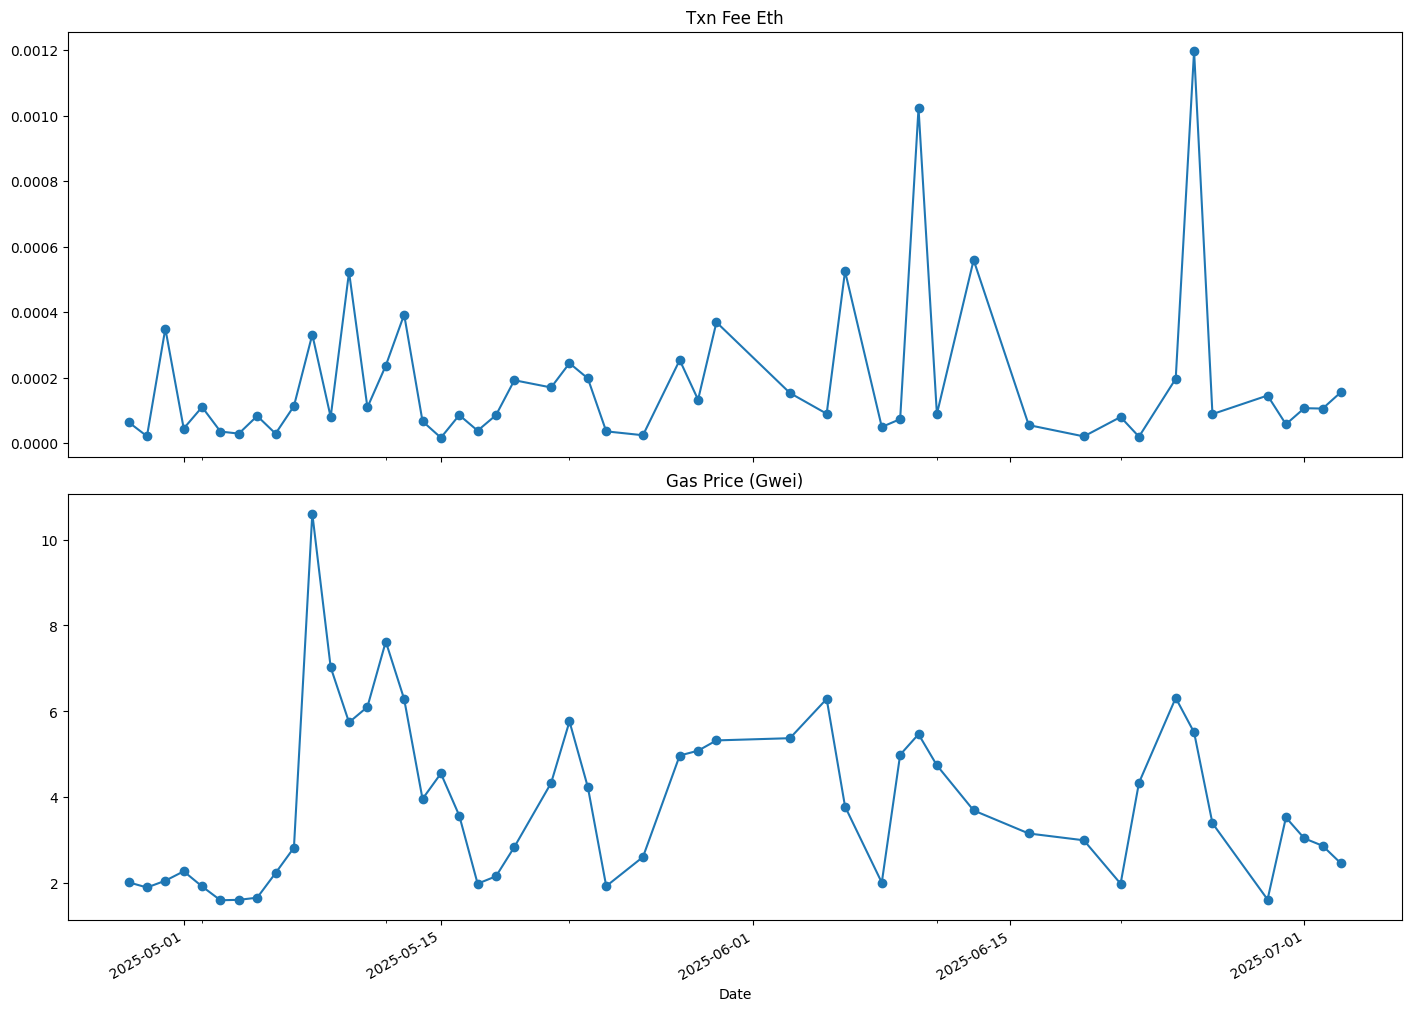

In [44]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (14,10), sharex=True, constrained_layout=True)

df_clean["TxnFee(ETH)"].head(50).plot(marker = "o", ax = ax1)
ax1.set_title("Txn Fee Eth")
ax1.set_xlabel("Date")

df_clean["Value (Gwei)"].head(50).plot(marker = "o", ax = ax2)
ax2.set_title("Gas Price (Gwei)")
ax2.set_xlabel("Date")



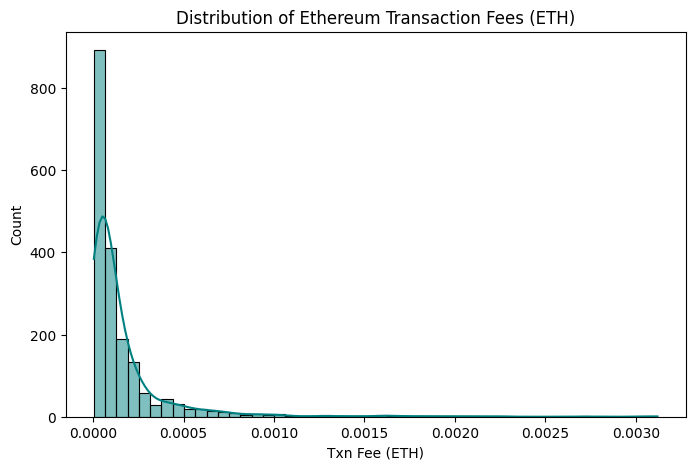

In [48]:
plt.figure(figsize=(8,5))
sns.histplot(df1['TxnFee(ETH)'], bins=50, kde=True, color='teal')
plt.title('Distribution of Ethereum Transaction Fees (ETH)')
plt.xlabel('Txn Fee (ETH)')
plt.show()


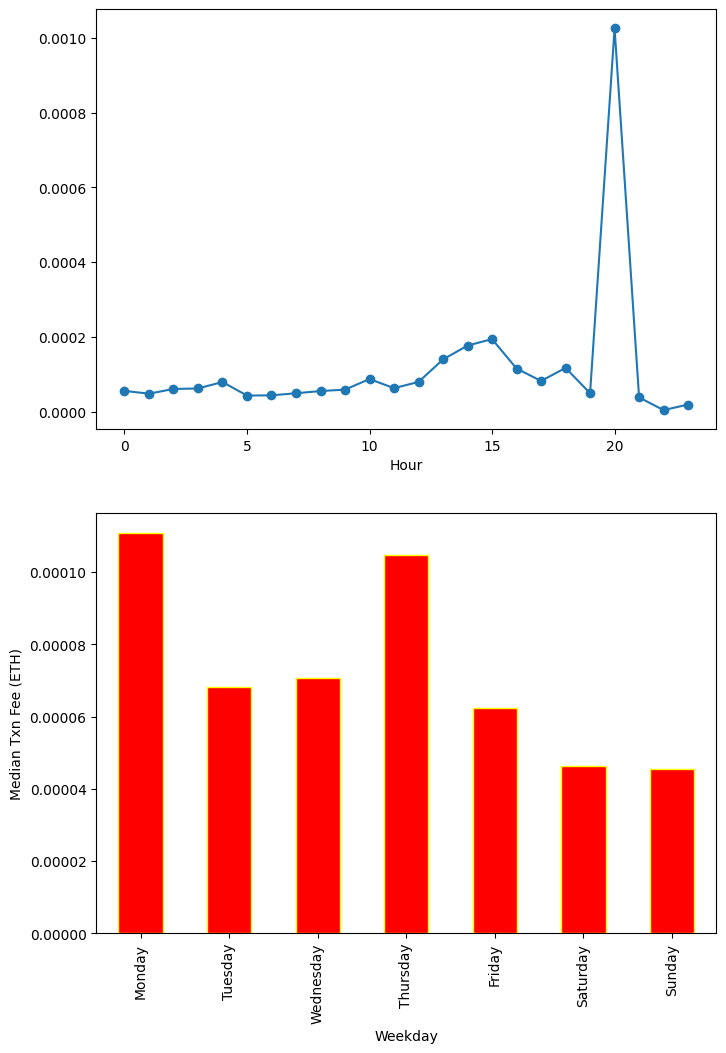

In [50]:
fig, (ax1, ax2) =  plt.subplots(nrows = 2, ncols = 1, figsize = (8,12))

hourly = df1.groupby("Hour")['TxnFee(ETH)'].median()
hourly.plot(ax = ax1, marker = "o")
ax1.set_xlabel("Hour")
ax2.set_ylabel("Median Txn Fee (ETH)")

weekday = df1.groupby("Weekday")['TxnFee(ETH)'].median().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
weekday.plot(kind = "bar", ax = ax2, color = "red", edgecolor = "yellow")
ax2.set_xlabel("Weekday")
ax2.set_ylabel("Median Txn Fee (ETH)")
plt.show()

In [47]:
df.head()

,Transaction Hash,Blockno,UnixTimestamp,DateTime (UTC),From,To,ContractAddress,Value_IN(ETH),Value_OUT(ETH),CurrentValue @ $4081.04274641846/Eth,TxnFee(ETH),TxnFee(USD),Historical $Price/Eth,Status,ErrCode,Method
0,0x9f749f8455c94f5ae9666e84dd11e891a4e675785aca...,22366772,1745833739,2025-04-28 09:48:59,0x6d3b90747dbf5883bf88ff7eb5fcc86f408b5409,0xb60acd2057067dc9ed8c083f5aa227a244044fd6,NaN,0.00000,0.0035,14.283650,0.000064,0.260016,1800.19,NaN,NaN,Request Unstake
1,0xcde436236c96578e99989de764506943b9a2e741f31c...,22371619,1745892287,2025-04-29 02:04:47,0xb4a3c2debfc033ee3399ad6adf0b4fc74db92baa,0x6d3b90747dbf5883bf88ff7eb5fcc86f408b5409,NaN,0.05870,0.0000,239.557209,0.000009,0.038739,1798.47,NaN,NaN,Transfer
2,0xe186980a9a92108d496c3cc87a3d67ed2084591f83cf...,22371854,1745895143,2025-04-29 02:52:23,0x6d3b90747dbf5883bf88ff7eb5fcc86f408b5409,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,NaN,0.00000,0.0000,0.000000,0.000021,0.084258,1798.47,NaN,NaN,Transfer
3,0x17cb03a81923f1ed2708cbcd1ab1991abd6623dbd864...,22371862,1745895239,2025-04-29 02:53:59,0x6d3b90747dbf5883bf88ff7eb5fcc86f408b5409,0xb60acd2057067dc9ed8c083f5aa227a244044fd6,NaN,0.00000,0.0035,14.283650,0.000078,0.318759,1798.47,NaN,NaN,Request Unstake
4,0xf88f300fa9936ed20f1383e499b8bf395e32fcbdb1b9...,22381870,1746016223,2025-04-30 12:30:23,0x102407f67415dcc4068370625ca27f24bb2a03d5,0x6d3b90747dbf5883bf88ff7eb5fcc86f408b5409,NaN,43.89617,0.0000,179142.148108,0.000011,0.045129,1793.83,NaN,NaN,Transfer


C:\Users\User\AppData\Local\Temp\ipykernel_8548\4051513205.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_weekend', y='TxnFee(ETH)', data=df1, palette='Set2')


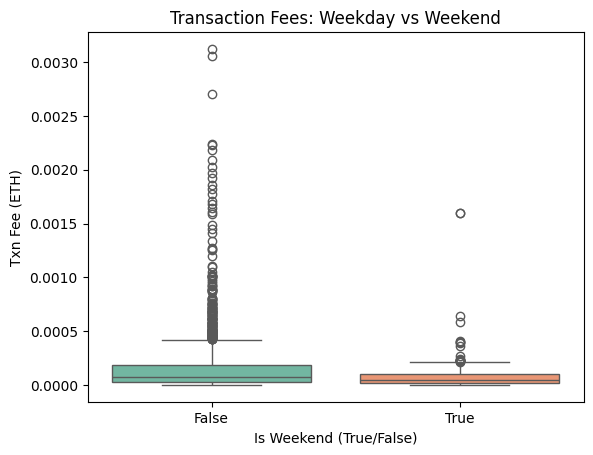

In [51]:
sns.boxplot(x='is_weekend', y='TxnFee(ETH)', data=df1, palette='Set2')
plt.title('Transaction Fees: Weekday vs Weekend')
plt.xlabel('Is Weekend (True/False)')
plt.ylabel('Txn Fee (ETH)')
plt.show()


Best (p,d,q): (5, 1, 5) AIC: 534.0108883016924


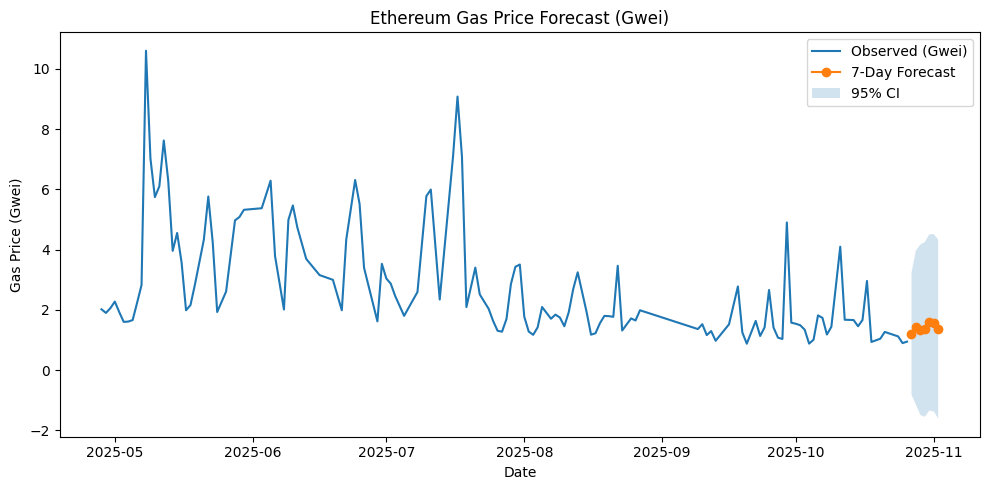

In [52]:
import itertools, warnings, numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# 0) Make sure index is datetime and sorted
df_clean.index = pd.to_datetime(df_clean.index)
df_clean = df_clean.sort_index()

# 1) Build a DAILY series (fill any gaps)
daily = (
    df_clean['Value (Gwei)']
    .resample('D').median()          # daily median (safe even if already daily)
    .interpolate('time')             # fill missing days smoothly
)

# 2) Grid search ARIMA(p,d,q) by AIC
p_max, d_vals, q_max = 5, [0, 1], 5
best_aic, best_order, best_result = np.inf, None, None

for p in range(p_max + 1):
    for d in d_vals:
        for q in range(q_max + 1):
            if p == d == q == 0:
                continue
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    res = ARIMA(
                        daily, order=(p, d, q),
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    ).fit()
                if res.aic < best_aic:
                    best_aic, best_order, best_result = res.aic, (p, d, q), res
            except Exception:
                pass

print("Best (p,d,q):", best_order, "AIC:", best_aic)

# 3) Forecast next 7 days
forecast = best_result.get_forecast(steps=7)
pred_mean = forecast.predicted_mean
ci = forecast.conf_int()  # 95% intervals

# 4) Plot
plt.figure(figsize=(10,5))
plt.plot(daily, label='Observed (Gwei)')
plt.plot(pred_mean, marker='o', label='7-Day Forecast')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2, label='95% CI')
plt.title('Ethereum Gas Price Forecast (Gwei)')
plt.ylabel('Gas Price (Gwei)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()


In [53]:
# If you used: forecast = best_result.get_forecast(steps=7)

preds = forecast.predicted_mean              # pandas Series (7 values)
cis   = forecast.conf_int()                  # DataFrame with lower/upper

out = pd.concat([preds, cis], axis=1)
out.columns = ["forecast_gwei", "lower_95", "upper_95"]

print(out)            # see the 7 daily predictions with dates
# out.to_csv("gas_forecast.csv", index=True)  # optional save


            forecast_gwei  lower_95  upper_95
2025-10-27       1.204973 -0.815102  3.225048
2025-10-28       1.417103 -1.145217  3.979423
2025-10-29       1.339902 -1.489330  4.169134
2025-10-30       1.350120 -1.553461  4.253702
2025-10-31       1.580978 -1.344799  4.506756
2025-11-01       1.572686 -1.372156  4.517528
2025-11-02       1.365949 -1.602849  4.334747


In [54]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, Range1d, LinearAxis
from bokeh.layouts import gridplot
from bokeh.io import output_notebook
from bokeh.palettes import Category10
import numpy as np

output_notebook()  # or output_file("gas_prices.html")

# ---------- Colors ----------
daily_color = Category10[10][0]   # daily line
ma7_color   = Category10[10][1]   # 7D MA line
wkday_color = Category10[10][2]   # Mon–Fri bars
wkend_color = Category10[10][3]   # Sat/Sun + weekend avg
pct_color   = Category10[10][4]   # % bar

# ---------- Series ----------
daily = df_clean["Value (Gwei)"].sort_index()
seven_ma = daily.rolling(7, min_periods=1).mean()

# ---------- Sources ----------
src_line = ColumnDataSource(data={
    "date": daily.index,
    "gwei": daily.values,
    "ma7":  seven_ma.values,
})

weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
weekday_median = (
    daily.groupby(daily.index.day_name())
    .median()
    .reindex(weekday_order)
)

weekday_fill = [wkend_color if d in ("Saturday","Sunday") else wkday_color
                for d in weekday_order]
src_weekday = ColumnDataSource(data={
    "weekday": weekday_median.index.tolist(),
    "median":  weekday_median.values.tolist(),
    "color":   weekday_fill,
})

is_weekday  = daily.index.dayofweek < 5
weekday_avg = float(daily[is_weekday].mean())
weekend_avg = float(daily[~is_weekday].mean())

# %Δ (signed for tooltip, positive magnitude for bar height)
pct_signed = 100.0 * (weekend_avg - weekday_avg) / max(weekday_avg, 1e-9)
pct_mag    = abs(pct_signed)
pct_label  = f"{pct_signed:+.1f}%"

cats      = ["Weekday Avg", "Weekend Avg", "% Δ (|Wknd−Wkday| / Wkday)"]
vals_gwei = [weekday_avg, weekend_avg, np.nan]  # NaN so % bar won't affect left autoscale
vals_pct  = [np.nan, np.nan, pct_mag]

src_avg = ColumnDataSource(data={
    "cat":       cats,
    "val":       vals_gwei,                     # Gwei bars (left axis)
    "val_pct":   vals_pct,                      # % bar (right axis)
    "color":     [wkday_color, wkend_color, pct_color],
    "pct_label": [None, None, pct_label],
})

# ---------- (1) Daily + 7D MA ----------
p1 = figure(x_axis_type="datetime", width=900, height=350,
            title="Daily Gas Price (Gwei)")
p1.line("date", "gwei", source=src_line, legend_label="Daily",
        color=daily_color, line_width=2)
p1.circle("date", "gwei", source=src_line, size=4,
          line_color=daily_color, fill_alpha=0.0)
p1.line("date", "ma7", source=src_line, legend_label="7D MA",
        color=ma7_color, line_width=3, alpha=0.9)
p1.add_tools(HoverTool(
    tooltips=[("Date", "@date{%F}"), ("Gwei", "@gwei{0.00}"), ("7D MA", "@ma7{0.00}")],
    formatters={"@date": "datetime"},
    mode="vline"
))
p1.legend.location = "top_right"
p1.xaxis.axis_label = "Date"
p1.yaxis.axis_label = "Value (Gwei)"

# ---------- (2) Weekday medians ----------
p2 = figure(x_range=weekday_order, width=450, height=300,
            title="Median Gas Price by Weekday (Gwei)")
p2.vbar(x="weekday", top="median", width=0.8, source=src_weekday,
        fill_color="color", line_color="color")
p2.xaxis.axis_label = "Weekday"
p2.yaxis.axis_label = "Median (Gwei)"
p2.add_tools(HoverTool(tooltips=[("Weekday", "@weekday"), ("Median", "@median{0.00}")]))
p2.xaxis.major_label_orientation = 0.8

# ---------- (3) Averages + % difference (secondary y-axis) ----------
p3 = figure(x_range=cats, width=450, height=300,
            title="Average Gas Price: Weekday vs Weekend (Gwei) + % Difference")

# Lock left axis scale so it doesn't change
max_gwei = max(weekday_avg, weekend_avg)
p3.y_range = Range1d(start=0, end=max_gwei * 1.25)
p3.yaxis.axis_label = "Average (Gwei)"

# Left-axis Gwei bars
r_gwei = p3.vbar(x="cat", top="val", width=0.6, source=src_avg,
                 fill_color="color", line_color="color")

# Right axis for percent
pct_pad = max(5, pct_mag * 0.4)
p3.extra_y_ranges = {"pct": Range1d(start=0, end=pct_mag + pct_pad)}
p3.add_layout(LinearAxis(y_range_name="pct", axis_label="Percent (%)"), 'right')

# % bar (positive height on the right axis)
r_pct = p3.vbar(x="cat", top="val_pct", width=0.45, source=src_avg,
                fill_color=pct_color, line_color=pct_color, y_range_name="pct")

# Hovers
p3.add_tools(HoverTool(renderers=[r_gwei],
                       tooltips=[("Group", "@cat"), ("Avg (Gwei)", "@val{0.00}")]))
p3.add_tools(HoverTool(renderers=[r_pct],
                       tooltips=[("Group", "@cat"), ("% Δ", "@pct_label")]))

# ---------- Layout ----------
layout = gridplot([[p1], [p2, p3]])
show(layout)


Loading BokehJS ...

## 🧠 **4. Conclusions and Insights**

1. **Weekday vs Weekend Costs:**  
   Both average gas prices and transaction fees are higher during weekdays (~40% difference), aligning with increased network activity and contract interactions during business hours.

2. **Wallet-Specific Activity Patterns:**  
   The analyzed wallet shows noticeable spikes in transaction fees around **19:00–21:00 UTC**, suggesting concentrated transaction periods — potentially automated or user-driven.

3. **Fee–Gas Relationship:**  
   Transaction fees do not perfectly follow gas prices since  
   \[
   \text{Txn Fee (ETH)} = \text{Gas Price (Gwei)} \times \text{Gas Used}
   \]  
   and gas used varies by transaction complexity.  
   Hence, even when network gas prices remain stable, wallet-level fees can fluctuate significantly.

4. **Predictability and Volatility:**  
   Both fees and gas prices display irregular, high-frequency fluctuations without clear seasonality.  
   The ARIMA forecast showed mild short-term trends but large confidence intervals, confirming **low predictability**.

5. **Overall Insight:**  
   Ethereum’s fee dynamics reflect a complex interaction between **user-level behavior (gas used)** and **network-level conditions (gas price)**.  
   Accurate forecasting would likely require integrating wallet data with broader indicators such as mempool congestion and transaction volume.